In [1]:
import typing
import numpy as np
import pandas as pd
import pangho
import interpretable as inter
import interpretable_linear_data as interData
import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.eager import context

tf.config.threading.set_inter_op_parallelism_threads(5)
_ = tf.Variable([1])

import DeepLearningInterpretable as DLI

In [2]:
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

tensorflow: 2.3.2


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import NonNeg 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from scipy.optimize import curve_fit
from pandas import Grouper as tg

scaler = StandardScaler()

In [4]:
# load clean data
%store -r dataf
# we store the desired data
mid = dataf['mid'][:2000000].copy()
returns = dataf['returns'][:2000000].copy()
qty_signed = dataf['qty_signed'][:2000000].copy()
epsilons = qty_signed.apply(lambda x: np.sign(x)).copy()

# we set the learning lag parameter
N = len(mid)
max_lag = 1000

# we can start the kernel regression

# we define the regression matrix for each method of learning
L = 500
A = inter.regression_matrix(qty_signed.values, L)

# we normalize for the training 
#row_std = A.std(axis=1)
#std_matrix = A / row_std[:, np.newaxis]
Y = returns.values[L:]

$\underline{\text{Curve fitting:}}$

In [5]:
def curve_fittingPL(v,a,b):
    return a*np.power(v,-b)

def curve_fittingExpo(v,a,b):
    return a*np.power(v,-b)

In [6]:
def plot_kernels(kernels, ax):
    for kernel in kernels: 
        ax.plot(kernels[kernel][1:], label = 'kernel approx with kernel:'+str(kernel))
        ax.set_title('regressed kernel ')
        ax.set_xlabel('t')
        ax.set_ylabel('Price ($)')
        ax.set_xlim((1,500))
        ax.legend()
        
def plot_loss(ax, history):
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('model loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper right')


In [7]:
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
optimizer = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)
batch_size = int(N/1000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

$\underline{\text{Power Model:}}$

In [8]:
nlm1, history1 = DLI.modelPowerLaw(A, Y, optimizer, batch_size, epochs = 100)

Epoch 1/100
701/701 [==============================] - 4s 6ms/step - loss: 1.3407e-05 - val_loss: 1.2829e-05
Epoch 2/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3289e-05 - val_loss: 1.2816e-05
Epoch 3/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3275e-05 - val_loss: 1.2813e-05
Epoch 4/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3267e-05 - val_loss: 1.2801e-05
Epoch 5/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3255e-05 - val_loss: 1.2807e-05
Epoch 6/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3251e-05 - val_loss: 1.2793e-05
Epoch 7/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3240e-05 - val_loss: 1.2786e-05
Epoch 8/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3235e-05 - val_loss: 1.2781e-05
Epoch 9/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3230e-05 - val_loss: 1.2773e-05
Epoch 10/100
701/70

701/701 [==============================] - 3s 5ms/step - loss: 1.3135e-05 - val_loss: 1.2705e-05
Epoch 76/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3134e-05 - val_loss: 1.2701e-05
Epoch 77/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3134e-05 - val_loss: 1.2700e-05
Epoch 78/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3134e-05 - val_loss: 1.2701e-05
Epoch 79/100
701/701 [==============================] - 3s 5ms/step - loss: 1.3133e-05 - val_loss: 1.2700e-05
Epoch 80/100
701/701 [==============================] - 4s 5ms/step - loss: 1.3133e-05 - val_loss: 1.2702e-05
Epoch 81/100
701/701 [==============================] - 4s 5ms/step - loss: 1.3133e-05 - val_loss: 1.2700e-05
Epoch 82/100
701/701 [==============================] - 4s 5ms/step - loss: 1.3133e-05 - val_loss: 1.2703e-05
Epoch 83/100
701/701 [==============================] - 4s 5ms/step - loss: 1.3132e-05 - val_loss: 1.2704e-05
Epoch 84/100
701/701 [=

In [9]:
GNNPL_approx_USB = pd.concat((pd.Series([0]), pd.Series(nlm1.layers[1].kernel.numpy().cumsum())))

In [10]:
params1, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNPL_approx_USB[1:] )
appro1 = curve_fittingPL(np.arange(1,L+1), *params1)

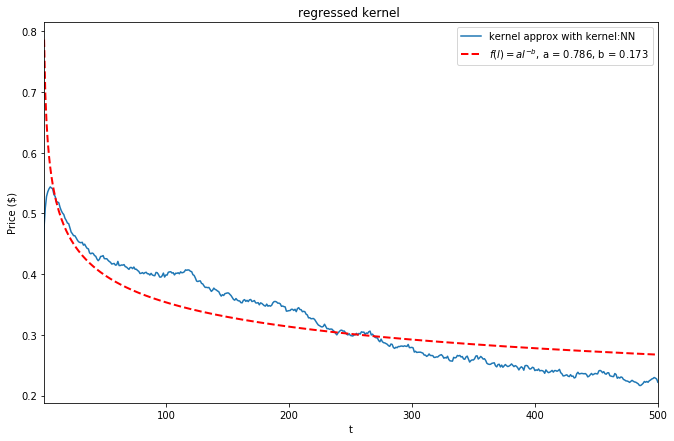

In [11]:
kernels = {'NN': GNNPL_approx_USB}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,L+1), appro1[:L+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params1[0])[:5] + ', b = ' + str(params1[1])[:5] )
ax.legend()

#plt.yscale('log')
#plt.ylim((-1e-5,2.8*1e-3))


plt.savefig('graphs_10YUSB/one_kernel_non_linear_regression_10YUSB.png')

In [12]:
alphaGNNPL_USB = nlm1.layers[0].kernel.numpy()[0]
%store GNNPL_approx_USB
%store alphaGNNPL_USB

Stored 'GNNPL_approx_USB' (Series)
Stored 'alphaGNNPL_USB' (float32)


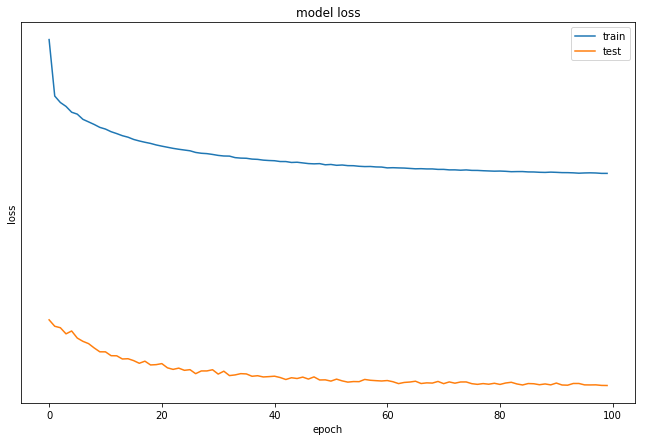

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_loss(ax, history1)
ax.set_yscale('log')
plt.savefig('graphs_10YUSB/loss_one_kernel_non_linear_regression_10YUSB.png')

In [14]:
returnsapproxGNNPL_USB = nlm1.predict(A)

In [31]:
R2_PowerModelGNNPL_USB = r2_score(Y, returnsapproxGNNPL_USB)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNPL_USB )

R^2 train (returns): 0.090


In [32]:
synthetic_variogram_GNNPL_approx_USB = inter.variogram2(returnsapproxGNNPL_USB.cumsum())
% store synthetic_variogram_GNNPL_approx_USB
% store returnsapproxGNNPL_USB
% store R2_PowerModelGNNPL_USB


Stored 'synthetic_variogram_GNNPL_approx_USB' (Series)
Stored 'returnsapproxGNNPL_USB' (ndarray)
Stored 'R2_PowerModelGNNPL_USB' (float64)


In [36]:
np.var(returnsapproxGNNPL_USB.cumsum())/np.var(Y.cumsum())

10.343428519382721

$\underline{\text{Double Propagator Model:}}$

In [17]:
# we create a new matrix. We concatenate the qty signed matrix with the sign matrix 
new_matrix2 = np.concatenate((A,A), axis = 1)
#new_matrix2 = std_matrix

In [18]:
new_matrix2.shape

(959456, 1002)

In [19]:
nlm5, history5 = DLI.modelDoublePowerLaw(new_matrix2, Y, optimizer, batch_size, epochs = 100)

Epoch 1/100
701/701 [==============================] - 11s 16ms/step - loss: 1.3894e-05 - val_loss: 1.3389e-05
Epoch 2/100
701/701 [==============================] - 10s 14ms/step - loss: 1.3779e-05 - val_loss: 1.3363e-05
Epoch 3/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3762e-05 - val_loss: 1.3308e-05
Epoch 4/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3370e-05 - val_loss: 1.2714e-05
Epoch 5/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3140e-05 - val_loss: 1.2710e-05
Epoch 6/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3138e-05 - val_loss: 1.2709e-05
Epoch 7/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3138e-05 - val_loss: 1.2704e-05
Epoch 8/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3137e-05 - val_loss: 1.2711e-05
Epoch 9/100
701/701 [==============================] - 10s 14ms/step - loss: 1.3137e-05 - val_loss: 1.2703e-05
Epoch 1

701/701 [==============================] - 10s 15ms/step - loss: 1.3130e-05 - val_loss: 1.2701e-05
Epoch 75/100
701/701 [==============================] - 11s 15ms/step - loss: 1.3130e-05 - val_loss: 1.2700e-05
Epoch 76/100
701/701 [==============================] - 11s 15ms/step - loss: 1.3129e-05 - val_loss: 1.2703e-05
Epoch 77/100
701/701 [==============================] - 10s 14ms/step - loss: 1.3129e-05 - val_loss: 1.2700e-05
Epoch 78/100
701/701 [==============================] - 9s 14ms/step - loss: 1.3129e-05 - val_loss: 1.2698e-05
Epoch 79/100
701/701 [==============================] - 9s 14ms/step - loss: 1.3129e-05 - val_loss: 1.2700e-05
Epoch 80/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3130e-05 - val_loss: 1.2699e-05
Epoch 81/100
701/701 [==============================] - 9s 13ms/step - loss: 1.3129e-05 - val_loss: 1.2699e-05
Epoch 82/100
701/701 [==============================] - 8s 11ms/step - loss: 1.3129e-05 - val_loss: 1.2700e-05
Epoch 83/1

In [20]:
GNNDPL_approx1_USB = pd.concat((pd.Series([0]), pd.Series(nlm5.layers[1].kernel[:501].numpy().cumsum())))
GNNDPL_approx2_USB = pd.concat((pd.Series([0]), pd.Series(nlm5.layers[1].kernel[501:].numpy().cumsum())))
alpha1DPL_USB = nlm5.layers[0].kernel.numpy()[0]
alpha2DPL_USB = nlm5.layers[0].kernel.numpy()[1]
%store GNNDPL_approx1_USB
%store GNNDPL_approx2_USB
%store alpha1DPL_USB
%store alpha2DPL_USB

Stored 'GNNDPL_approx1_USB' (Series)
Stored 'GNNDPL_approx2_USB' (Series)
Stored 'alpha1DPL_USB' (float32)
Stored 'alpha2DPL_USB' (float32)


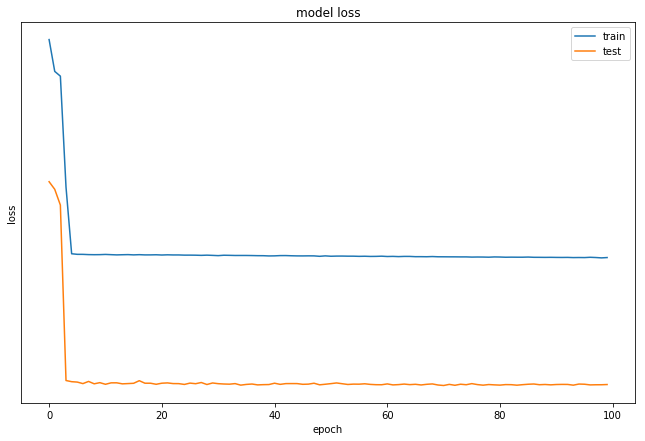

In [21]:
fig, (ax) = plt.subplots(1, 1, figsize=[11, 7])
plot_loss(ax, history5)
ax.set_yscale('log')
plt.savefig('graphs_10YUSB/loss_bi_power_law_kernel_non_linear_regression_10YUSB.png')

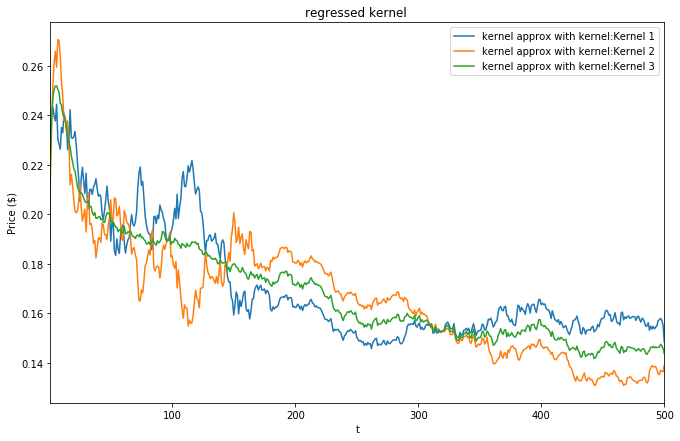

In [22]:
kernels = {'Kernel 1': GNNDPL_approx1_USB, 'Kernel 2': GNNDPL_approx2_USB, 'Kernel 3': (GNNDPL_approx1_USB+GNNDPL_approx2_USB)/2}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

'''ax.plot(np.arange(1,max_lag+2), appro2[:max_lag+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params2[0])[:5] + ', b = ' + str(params2[1])[:5] )

ax.plot(np.arange(451,max_lag+2), appro3[450:max_lag+1], '--b', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params3[0])[:5] + ', b = ' + str(params3[1])[:5] )
ax.legend()

ax.plot(np.arange(20,431), appro1[20:431], '--g', linewidth=2, 
label = r'$f(l) = ae^{-bl}$' + ', a = ' + str(params1[0])[:5] + ', b = ' + str(params1[1])[:5] )
ax.legend()

plt.plot(np.zeros(1001))
plt.ylim((-1e-5,3*1e-3))'''

plt.savefig('graphs_10YUSB/bi_kernel_non_linear_regression_10YUSB.png')

In [23]:
print(alpha1DPL_USB)
print(alpha2DPL_USB)

0.3459408
0.3465663


In [24]:
returnsapproxDoublePL_USB = nlm5.predict(new_matrix2)

In [33]:
R2_DoublePowerModel_USB = r2_score(Y, returnsapproxDoublePL_USB)
print('R^2 train (returns): %.3f' % R2_DoublePowerModel_USB )

R^2 train (returns): 0.090


In [34]:
synthetic_variogram_GNNDoublePL_approx_USB = inter.variogram2(returnsapproxDoublePL_USB.cumsum())
% store synthetic_variogram_GNNDoublePL_approx_USB
% store returnsapproxDoublePL_USB
% store R2_DoublePowerModel_USB


Stored 'synthetic_variogram_GNNDoublePL_approx_USB' (Series)
Stored 'returnsapproxDoublePL_USB' (ndarray)
Stored 'R2_DoublePowerModel_USB' (float64)


In [35]:
np.var(returnsapproxDoublePL_USB.cumsum())/np.var(Y.cumsum())

20.86273681070642

$\underline{\text{Models trained with symmetry:}}$

$\underline{\text{Model1:}}$

In [ ]:
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
optimizer = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.01)
batch_size = int(N/10000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [ ]:
nlm3, history3 = DLI.modelPowerLaw(std_matrix, Y, optimizer, batch_size, epochs = 200, symmetry = True)

In [ ]:
alpha31 = nlm3.layers[2].kernel.numpy()[0]
alpha32 = nlm3.layers[3].kernel.numpy()[0]
print( 'alpha branch1: %.3f, alpha branch2: %.3f' % (alpha31,alpha32) )

In [ ]:
GNN3_approx1 = pd.concat((pd.Series([0]), pd.Series(nlm3.layers[4].kernel.numpy().cumsum())))
GNN3_approx2 = pd.concat((pd.Series([0]), pd.Series(nlm3.layers[5].kernel.numpy().cumsum())))

In [ ]:
params31, cov = curve_fit(curve_fittingPL, np.arange(600,max_lag+2), GNN3_approx1[600:] )
appro31 = curve_fittingPL(np.arange(1,N+1), *params31)

params32, cov = curve_fit(curve_fittingPL, np.arange(600,max_lag+2), GNN3_approx2[600:] )
appro32 = curve_fittingPL(np.arange(1,N+1), *params32)

params33, cov = curve_fit(curve_fittingPL, np.arange(5,200), GNN3_approx1[5:200] )
appro33 = curve_fittingPL(np.arange(1,N+1), *params33)

params34, cov = curve_fit(curve_fittingPL, np.arange(5,200), GNN3_approx2[5:200] )
appro34 = curve_fittingPL(np.arange(1,N+1), *params34)

In [ ]:
kernels = {'Kernel 1': GNN3_approx1, 'Kernel 2': GNN3_approx2}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

'''ax.plot(np.arange(1,max_lag+2), appro31[:max_lag+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params31[0])[:5] + ', b = ' + str(params31[1])[:5] )

ax.plot(np.arange(1,max_lag+2), appro32[:max_lag+1], '--b', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params32[0])[:5] + ', b = ' + str(params32[1])[:5] )
ax.legend()

ax.plot(np.arange(1,max_lag+2), appro33[:max_lag+1], '--b', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params33[0])[:5] + ', b = ' + str(params33[1])[:5] )

ax.plot(np.arange(1,max_lag+2), appro34[:max_lag+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params34[0])[:5] + ', b = ' + str(params34[1])[:5] )'''
ax.legend()

#plt.yscale('log')
#plt.xscale('log')
plt.ylim((-1e-5,3*1e-3))

plt.savefig('graphs_10YUSB/symmetrical_one_kernel_non_linear_regression_10YUSB.png')

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_loss(ax, history3)
ax.set_yscale('log')
plt.savefig('graphs_10YUSB/loss_symmetrical_kernel_non_linear_regression_10YUSB.png')

In [ ]:
returnsapprox3 = nlm3.predict([std_matrix, -std_matrix])

In [ ]:
print('R^2 train: %.3f' % r2_score(Y, returnsapprox3[0]) )

$\underline{\text{Model2:}}$

In [ ]:
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
optimizer = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.01)
batch_size = int(N/10000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [ ]:
nlm4, history4 = DLI.modelPowerLawDoubleGen(new_matrix, Y, optimizer, batch_size, symmetry = True)

In [ ]:
GNN4_approx11 = pd.concat((pd.Series([0]), pd.Series(nlm4.layers[4].kernel.numpy().cumsum()[1001:])))
GNN4_approx12 = pd.concat((pd.Series([0]), pd.Series(nlm4.layers[4].kernel.numpy().cumsum()[1001:])))

GNN4_approx21 = pd.concat((pd.Series([0]), pd.Series(nlm4.layers[5].kernel.numpy().cumsum()[:1001])))
GNN4_approx22 = pd.concat((pd.Series([0]), pd.Series(nlm4.layers[5].kernel.numpy().cumsum()[1001:])))

In [ ]:
kernels = {'Kernel 11': GNN4_approx11, 'Kernel 12': GNN4_approx12, 'Kernel 21': GNN4_approx21, 'Kernel 22': GNN4_approx22}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

ax.legend()

#plt.plot(np.zeros(1001))

#plt.yscale('log')
#plt.ylim((-1e-5,3*1e-3))

plt.savefig('graphs_10YUSB/bi_symmetric_kernel_non_linear_regression_10YUSB.png')

In [ ]:
returnsapprox4 = nlm4.predict([new_matrix, -new_matrix])

In [ ]:
print('R^2 train: %.3f' % r2_score(Y, returnsapprox4) )